In [2]:
import torch
import torch.nn.functional as F
from torchvision import transforms, datasets
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
import sys
import os

In [3]:
sys.path.append(os.path.abspath('..'))
from models.model_v1 import get_model

In [4]:
MODEL_PATH = '../models/model_v1.pth'
DATA_DIR = '../data/PlantVillage'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [9]:
full_dataset = datasets.ImageFolder(DATA_DIR)
num_classes = len(full_dataset.classes)

print(f"Loading model for {num_classes} classes...")
model = get_model(num_classes=num_classes)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.to(DEVICE)
model.eval()

Loading model for 15 classes...


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [25]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        
        # Hook the gradients and activations
        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def __call__(self, x, class_idx=None):
        # Forward pass
        output = self.model(x)
        if class_idx is None:
            class_idx = torch.argmax(output)
        
        # Backward pass
        self.model.zero_grad()
        class_loss = output[0, class_idx]
        class_loss.backward()

        # Generate Heatmap
        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
        activation = self.activations[0]
        
        for i in range(activation.shape[0]):
            activation[i, :, :] *= pooled_gradients[i]
            
        heatmap = torch.mean(activation, dim=0).cpu().detach()
        heatmap = np.maximum(heatmap, 0) # ReLU
        heatmap /= torch.max(heatmap)    # Normalize
        
        return heatmap.numpy()

In [60]:
grad_cam = GradCAM(model, model.layer4[1].conv2)

# Pick a random image from the dataset
# You can also point this to a specific file path: img_path = "path/to/leaf.jpg"
import random
random_idx = random.randint(0, len(full_dataset))
img_path, label_idx = full_dataset.samples[random_idx]
class_name = full_dataset.classes[label_idx]

print(f"Visualizing: {class_name}")

# Prepare image
raw_image = Image.open(img_path).convert('RGB')
input_tensor = transform(raw_image).unsqueeze(0).to(DEVICE)

# Generate Heatmap
heatmap = grad_cam(input_tensor, class_idx=label_idx)

Visualizing: Tomato_Early_blight


/tmp/ipykernel_376075/2463205575.py:36: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  heatmap = np.maximum(heatmap, 0) # ReLU


/tmp/ipykernel_376075/849817893.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  img_np = np.array(raw_image.resize((224, 224)))


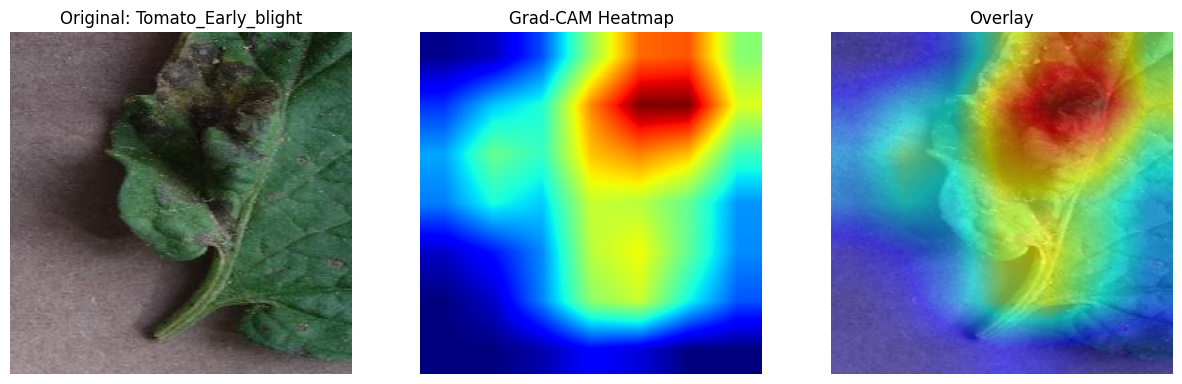

Saved visualization to results/gradcam_Tomato_Early_blight.png


In [61]:
img_np = np.array(raw_image.resize((224, 224)))
heatmap_resized = cv2.resize(heatmap, (224, 224))
heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)

# Superimpose
superimposed = np.float32(heatmap_colored) / 255 + np.float32(img_np) / 255
superimposed = superimposed / np.max(superimposed)

# Display
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(raw_image)
ax[0].set_title(f"Original: {class_name}")
ax[0].axis('off')

ax[1].imshow(heatmap_resized, cmap='jet')
ax[1].set_title("Grad-CAM Heatmap")
ax[1].axis('off')

ax[2].imshow(np.uint8(255 * superimposed))
ax[2].set_title("Overlay")
ax[2].axis('off')

plt.savefig(f"../results/gradcam_{class_name}.png") # Save for your Report
plt.show()

print(f"Saved visualization to results/gradcam_{class_name}.png")